# Probing Syntax in LLMs
by Lars Kulbe, Maxim Kurvink & Ole Jürgensen

#### Import libraries

In [2]:
import os
import requests

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import transformer_lens

from io import StringIO, BytesIO
from conllu import parse_incr
from IPython.display import Image, display
from PIL import Image as PILImage


/home/c13745859/anaconda3/envs/syntax_probing/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Introduction to Parsing Trees & Dataset

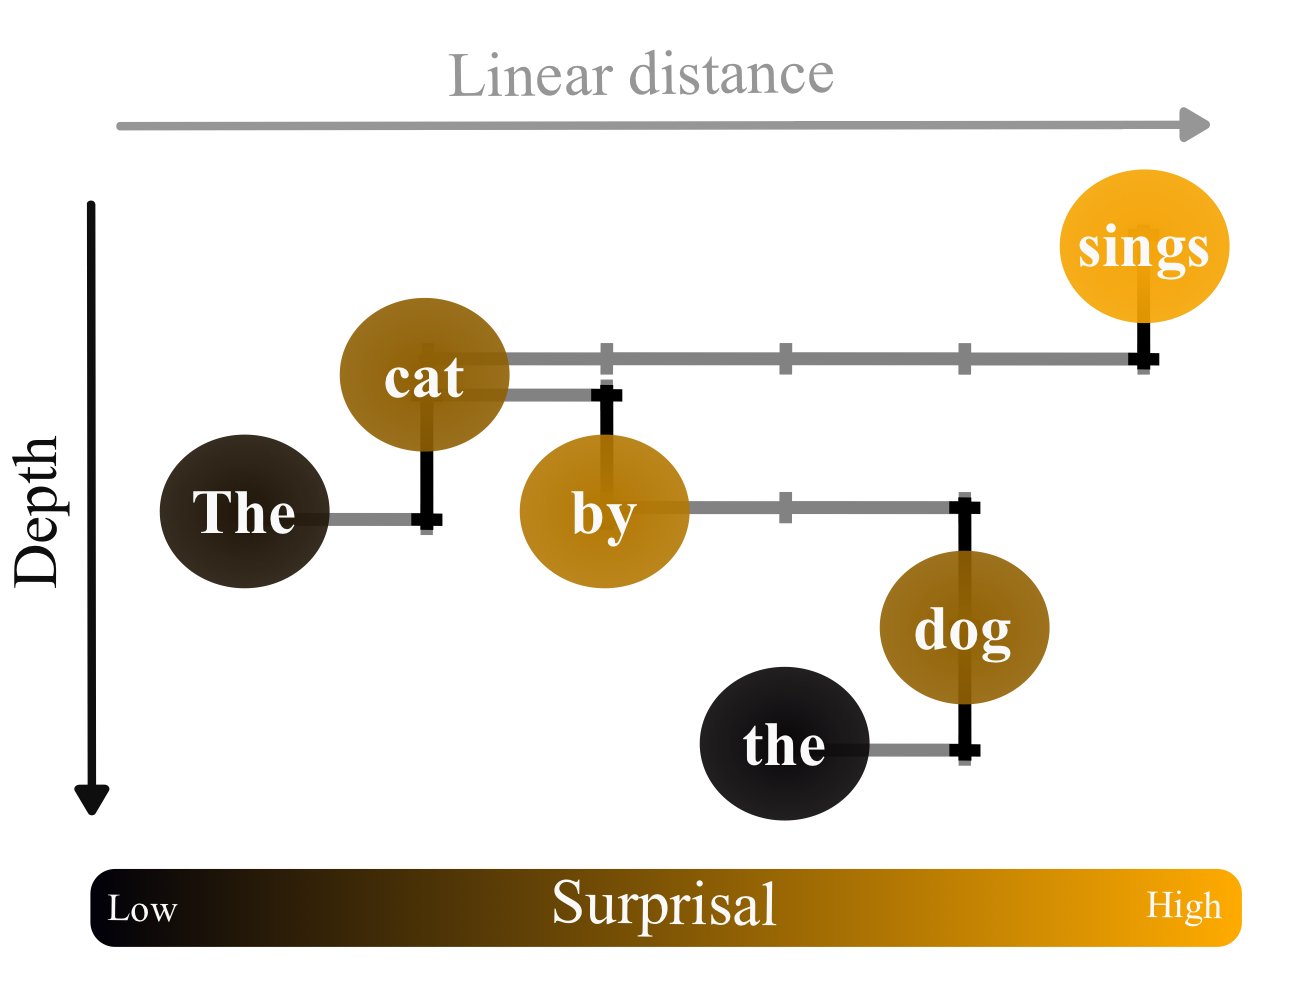

In [51]:
image_path = "images/tree_example.jpeg"
display(Image(filename=image_path, width=400, height=300))

The image adpated from Diego-Simon et al. (2025) depicts a typical **dependency based parse** tree for a short sentence. Nodes in the tree represent words or tokens, and edges represent immediate dependencies. Nodes connecting to a node at the lower level, are referred to as that nodes **parent**, while the lower node is called the **child**. At the lowest depth, we fnd the **root** of the sentence (sings), which will be main verb if the sentence. The children of a node can be thought of as adding information to the parent. In this example, the prepositional phrase "by the dog" modifies the subject "cat".

To construct these trees, we require hand-annoted sentences. We use the Universal Dependencies - English Dependency Treebank Universal Dependencies English Web Treebank (v2.17 -- 2025-11-15) data, which is openly available on their GitHub repository.

In [60]:
# load data
sentences_train = []
sentences_test = []

root_url = "https://raw.githubusercontent.com/UniversalDependencies/UD_English-EWT/master/"
files = {
    "test": "en_ewt-ud-test.conllu", 
    "train": "en_ewt-ud-train.conllu"
    }

for key, file in files.items():
    file_url = os.path.join(root_url, file)
    response = requests.get(file_url)
    response.raise_for_status()


    file_content = StringIO(response.text)
    for sentence in parse_incr(file_content):
        if key == "test":
            sentences_test.append(sentence)
        if key == "train":
            sentences_train.append(sentence)

print("There are {} training sentences and {} test sentences.".format(len(sentences_train), len(sentences_test)))

There are 12544 training sentences and 2077 test sentences.


Print some example sentences:

In [61]:
def sentence_to_string(sentence):
    """Convert a list of tokens (UD sentence object) to a readable string."""
    return " ".join(tok['form'] for tok in sentence if isinstance(tok['id'], int))

print("Example sentences:")
for i in np.random.randint(0, len(sentences_train), size = 5):
    print(sentence_to_string(sentences_train[i]))

Example sentences:
If no one objects , I will be the lead coordinator on Florida starting tomorrow .
Fuck you .
In short , China has the American economy by the throat .
With higher than average prices to boot !
Fedayeen are now visible on the street and they have become bolder than ever .


The dependecy tree structure can be decribed by a single variable (head), specifying the **parent** of a given word.

In [91]:
print(sentence_to_string(sentences_test[60]))
print("")
for tok in sentences_test[60]:
    print(str(tok['id']).ljust(3), tok['form'].ljust(12), ' --> ', sentences_test[60][tok['head']-1]['form'] if tok['head'] != 0 else 'ROOT')

I had to go to the BBC for this report .

1   I             -->  had
2   had           -->  ROOT
3   to            -->  go
4   go            -->  had
5   to            -->  BBC
6   the           -->  BBC
7   BBC           -->  go
8   for           -->  report
9   this          -->  report
10  report        -->  go
11  .             -->  had


Based on this we can reconstruct the parse tree distances using the lowest common ancestor (LCA; not to be confused with Latent Class Analysis). Direct links have a distance of 1, if there is one node sperating, them the distance is 2, and so on.

<Axes: >

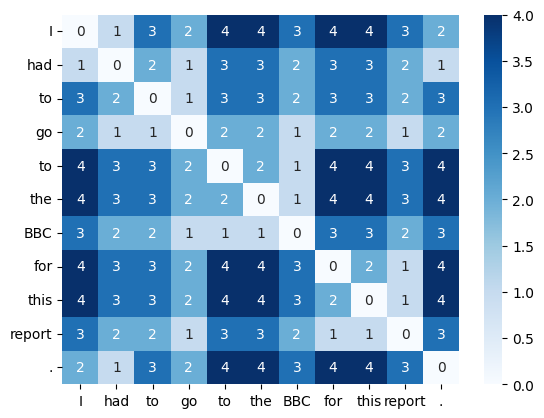

In [152]:
# expand to see function
def distance_matrix_from_sentence(sentence):
    """
    Return (matrix, ids) where matrix[i,j] is the discrete tree distance
    (number of edges) between token ids[i] and ids[j].
    Expects tokens with integer 'id' and 'head' (head==0 means ROOT).
    """

    forms = [tok['form'] for tok in sentence]
    ids = [tok['id'] for tok in sentence if isinstance(tok['id'], int)]
    parent = {tok['id']: (tok['head'] if tok['head'] != 0 else None) for tok in sentence if isinstance(tok['id'], int)}
    
    # Find the root token's id (where head == 0)
    root_id = next(tok['id'] for tok in sentence if isinstance(tok['id'], int) and tok['head'] == 0)
    id_to_idx = {tid: idx for idx, tid in enumerate(ids)}
    root_idx = id_to_idx[root_id]

    def ancestors(n):
        path = [n]
        while parent.get(path[-1]) is not None:
            path.append(parent[path[-1]])
        return path  # from node up to root

    depths = {i: len(ancestors(i)) - 1 for i in ids}  # distance to root
    n = len(ids)
    mat = np.zeros((n, n), dtype=int)

    # compute pairwise distances via lowest common ancestor (LCA)
    for i, a in enumerate(ids):
        anc_a = ancestors(a)
        set_anc_a = set(anc_a)
        for j, b in enumerate(ids):
            if i == j:
                continue
            anc_b = ancestors(b)
            # find first common ancestor when walking from node b up (closest to b)
            lca = next((x for x in anc_b if x in set_anc_a), None)
            mat[i, j] = depths[a] + depths[b] - 2 * depths[lca]

    root_dist = mat[root_idx, :]
    return mat, ids, root_dist, forms


mat, ids, root_dist, forms = distance_matrix_from_sentence(sentences_test[60])
sns.heatmap(mat, xticklabels=forms, yticklabels=forms, cmap="Blues", annot=True)

We can transfrom the distance matrix into a dependency based parsing tree using the networkx library. We obtain the minimum spanning tree through Kruskal's algorithm. Note that we manually set the node positions by their order in the sentence (x-axis) and their distance from the root (i.e. depth; y-axis).

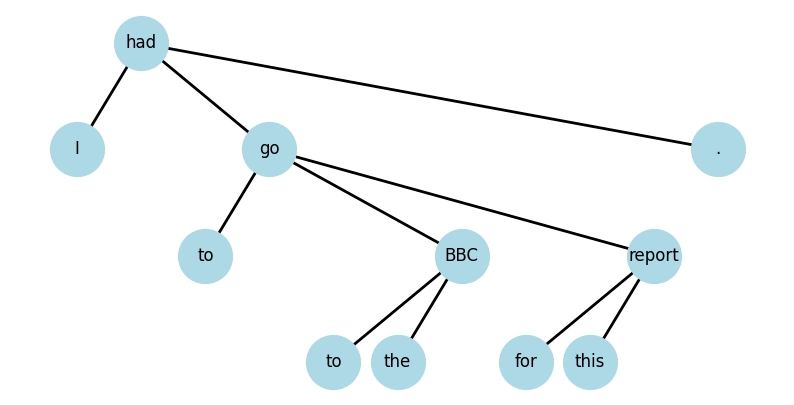

In [153]:
def graph_from_distance_matrix(mat, ids, root_dist, forms, ax=None, node_size = 1500, font_size = 12, width = 2):

    # Compute MST using Kruskal’s algorithm
    G = nx.from_numpy_array(mat)
    mst = nx.minimum_spanning_tree(G, algorithm="kruskal")
    # get adjacency matrix
    adj_matrix = nx.to_numpy_array(mst)
    # Prepare node positions: x=ids, y=root_dist
    pos = {i: (id, len(root_dist) - root_dist[idx]) for idx, (i, id) in enumerate(zip(range(len(ids)), ids))}

    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
    nx.draw(
        mst,
        pos=pos,
        ax=ax,
        with_labels=True,
        labels={i: forms[i] for i in range(len(forms))},
        node_color='lightblue',
        edge_color='black',
        node_size=node_size,
        font_size=font_size,
        width=width,
    )
    ax.set_xlabel("ids")
    ax.set_ylabel("root_dist")

    return adj_matrix, ax

fig, axs = plt.subplots(1, 1, figsize=(10, 5))
graph_from_distance_matrix(mat, ids, root_dist, forms, ax=axs)
plt.show()

Lets do this for some more sentences:

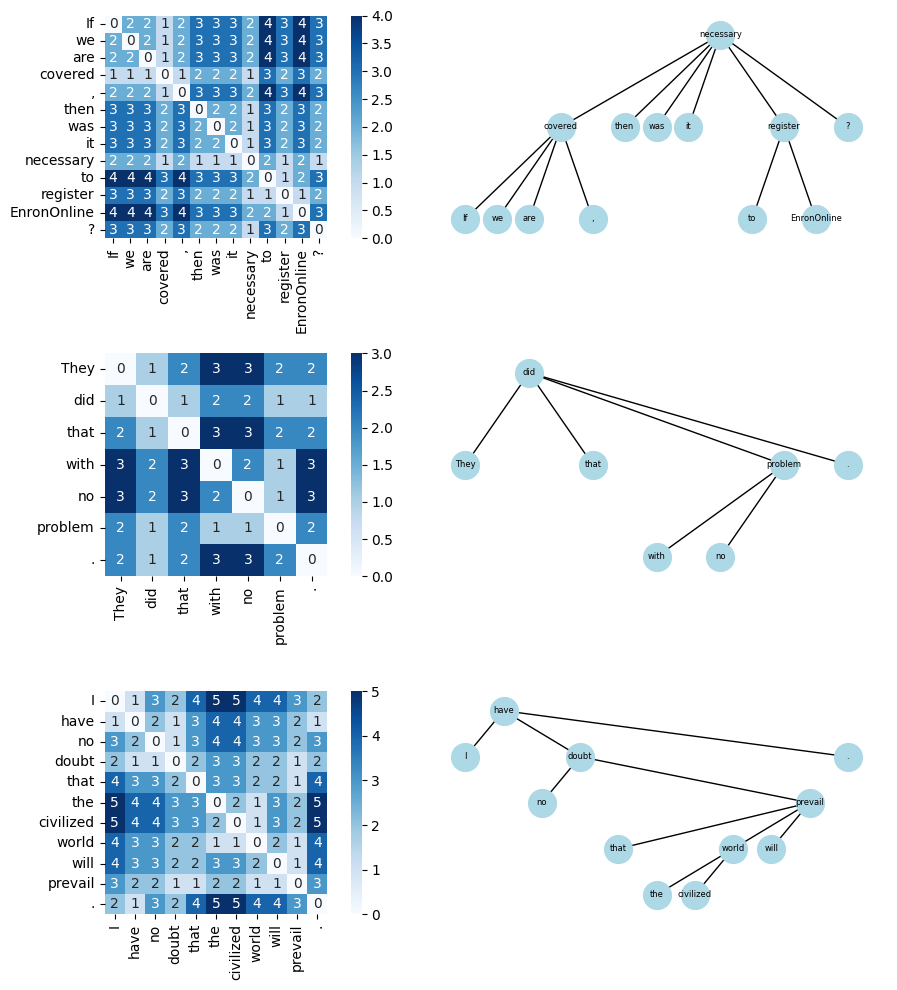

In [ ]:
num_sentences = 3
fig, axs = plt.subplots(3, 2, figsize=(10, 10))

np.random.seed(123) # note that the sentences can be quite long, if the seed is changed
for i, id in enumerate(np.random.randint(0, len(sentences_train), size = num_sentences)):
    mat, ids, root_dist, forms = distance_matrix_from_sentence(sentences_train[id])
    sns.heatmap(mat, xticklabels=forms, yticklabels=forms, cmap="Blues", annot=True, ax = axs[i, 0], square =True)
    graph_from_distance_matrix(mat, ids, root_dist, forms, ax=axs[i, 1], node_size = 400, font_size = 6, width = 1)
plt.tight_layout()

## Research Question

Our goal is to evaluate the syntactic knowledge of a large language model (LLM), by testing how well its hidden states encode this parse tree.

In [ ]:
# Load a GPT-2 Small model
model = transformer_lens.HookedTransformer.from_pretrained("gpt2-small")

Loaded pretrained model gpt2-small into HookedTransformer


torch.Size([1, 3, 50257])

In [19]:
# Run the model and get logits and activations
logits, activations = model.run_with_cache(["I love natural language processing.", "So much fun!"])
#for key in activations.keys():
    #print(key)

print(activations["blocks.11.hook_mlp_out"].shape)  # (1, 7, 1600) for "I love natural language processing."

torch.Size([2, 7, 768])


## References